<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/tidy_model_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tidymodel Stacking with R

[**stacks**](https://stacks.tidymodels.org/index.html) is an R package for model stacking that aligns with the tidy models. Model stacking is an ensembling method that combines the outputs of many models and combines them to generate a new model---an ensemble in this package that generates predictions informed by each of its members.

The process goes something like this:

1.  Define candidate ensemble members using functionality from [rsample](https://rsample.tidymodels.org/), [parsnip](https://parsnip.tidymodels.org/), [workflows](https://workflows.tidymodels.org/), [recipes](https://recipes.tidymodels.org/), and [tune](https://tune.tidymodels.org/).

2.  Initialize a `data_stack` object with [`stacks()`](https://stacks.tidymodels.org/reference/stacks.html)

3.  Iteratively add candidate ensemble members (base models) to the `data_stack` with [`add_candidates()`](https://stacks.tidymodels.org/reference/add_candidates.html)

4.  Evaluate how to combine their predictions with [`blend_predictions()`](https://stacks.tidymodels.org/reference/blend_predictions.html)

5.  Fit candidate ensemble members with non-zero stacking coefficients with [`fit_members()`](https://stacks.tidymodels.org/reference/fit_members.html)

6.  Predict on new data with [`predict()`](https://rdrr.io/r/stats/predict.html)



### Install Packages

In [1]:
install.packages("tidymodels")
install.packages("stacks")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lobstr’, ‘RcppEigen’, ‘butcher’, ‘glmnet’




#### Load Packages

In [2]:
library(tidymodels)
library(tidyverse)
library(stacks)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.0 ──

✔ broom        1.0.5     ✔ recipes      1.0.6
✔ dials        1.2.0     ✔ rsample      1.1.1
✔ dplyr        1.1.2     ✔ tibble       3.2.1
✔ ggplot2      3.4.2     ✔ tidyr        1.3.0
✔ infer        1.0.4     ✔ tune         1.1.1
✔ modeldata    1.1.0     ✔ workflows    1.1.3
✔ parsnip      1.1.0     ✔ workflowsets 1.0.1
✔ purrr        1.0.1     ✔ yardstick    1.2.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ lubridate 1.9.2     ✔ stringr   1.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──


Data

In [3]:
#mf<-read_csv("/content/sample_data/gp_soil_data_syn.csv")
# define file from my github
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data_syn.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, TPI,MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 1408 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): NLCD, FRG
dbl (8): ID, SOC, DEM, Slope, TPI, MAP, MAT, NDVI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,408
Columns: 9
$ SOC   <dbl> 1.900, 2.644, 0.800, 0.736, 15.641, 8.818, 3.782, 6.641, 4.803, …
$ DEM   <dbl> 2825.1111, 2535.1086, 1716.3300, 1649.8933, 2675.3113, 2581.4839…
$ Slope <dbl> 18.981682, 14.182393, 1.585145, 9.399726, 12.569353, 6.358553, 1…
$ TPI   <dbl> -0.91606224, -0.15259802, -0.39078590, -2.54008722, 7.40076303, …
$ MAT   <dbl> 4.709227, 4.648000, 6.360833, 10.265385, 2.798550, 6.358550, 7.0…
$ MAP   <dbl> 613.6979, 597.7912, 201.5091, 298.2608, 827.4680, 679.1392, 508.…
$ NDVI  <dbl> 0.6845260, 0.7557631, 0.2215059, 0.2785148, 0.7337426, 0.7017139…
$ NLCD  <chr> "Forest", "Forest", "Shrubland", "Shrubland", "Forest", "Forest"…
$ FRG   <chr> "Fire Regime Group IV", "Fire Regime Group IV", "Fire Regime Gro…


### Split data

In [4]:
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()

# Set 10 fold cross-validation data set
set.seed(136)
cv_folds <- vfold_cv(train, v = 5)

### The basic recipe used in all models

In [5]:
soc_rec <-
  recipe(SOC ~ ., data = train) %>%
  step_zv(all_predictors()) %>%
  step_dummy(all_nominal()) %>%
  step_normalize(all_numeric_predictors())

### Basic workflow

In [6]:
soc_wf <-
  workflow() %>%
  add_recipe(soc_rec)

### Control Rapper Function

Supply these light wrappers as the control argument in a tune::tune_grid(), tune::tune_bayes(), or tune::fit_resamples() call to return the needed elements for use in a data stack. These functions will return the appropriate control grid to ensure that assessment set predictions and information on model specifications and preprocessors is supplied in the resampling results object!

To integrate stack settings with your existing control settings, note that these functions call the appropriate ⁠tune::control_*⁠ function with the arguments ⁠save_pred = TRUE, save_workflow = TRUE⁠.

In [7]:
ctrl_grid <- control_stack_grid()
ctrl_res <- control_stack_resamples()

### Base-Models

We will use five regression models to create a stacked ensemble model:

1. GLM - Regularization Regression

Generalized Linear Models (GLMs) with regularization, often referred to as regularized regression, are extensions of the traditional linear regression that add regularization terms to the cost function. Regularization helps prevent overfitting and can improve the model's generalization performance by discouraging overly complex models.

In traditional linear regression, the objective is to minimize the sum of squared errors (SSE) between the predicted values and the actual target values. However, in regularized regression, an additional penalty term is added to the cost function. There are two common types of regularization used in regularized regression:

In [8]:
# Model Specification
glm_spec <-
  linear_reg(
   penalty = tune(),
   mixture=tune(),
  ) %>%
  set_mode("regression") %>%
  set_engine("glmnet")

# Workflow
glm_wflow <-
  soc_wf %>%
  add_model(glm_spec)

# Recipe
set.seed(1)
glm_res <-
  tune_grid(
    object = glm_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

2. Fandom Forest

We will use the ranger package to build random forest models. ranger is a fast and efficient implementation of random forest algorithms, known for its speed and scalability. The tidymodels provides a comprehensive framework for building, tuning, and evaluating random forest model while following the principles of the tidyverse.

In [9]:
install.packages("ranger")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
# Model Specification
rf_spec <-
  rand_forest(
    mtry = tune(),
    min_n = tune(),
    trees = 500
  ) %>%
  set_mode("regression") %>%
  set_engine("ranger")

# Workflow
rf_wflow <-
  soc_wf %>%
  add_model(rf_spec)

# Recipe
set.seed(1)
rf_res <-
  tune_grid(
    object = rf_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

i Creating pre-processing data to finalize unknown parameter: mtry



3. Light GBM

The tidymodels provides a comprehensive framework for building, tuning, and evaluating LightGBM model while following the principles of the tidyverse.

Parsnip could not support an implementation for boost_tree regression model specifications using the lightgbm engine. The parsnip extension package "bonsai" implements support for this specification. We need to install it and load to continue.

In [11]:
install.packages("lightgbm")
install.packages("bonsai")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [12]:
# Model Specification
lightgbm_spec<-
  boost_tree(
    mtry = tune(),
    trees = 500,
    min_n = tune(),
    tree_depth = tune(),
    loss_reduction = tune(),
    learn_rate = tune(),
    sample_size = 0.75
  ) %>%
  set_mode("regression") %>%
  set_engine("lightgbm")

# Workflow
library(bonsai)
lightgbm_wflow <-
  soc_wf %>%
  add_model(lightgbm_spec)

# Recipe
set.seed(1)
lightgbm_res <-
  tune_grid(
    object = lightgbm_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

i Creating pre-processing data to finalize unknown parameter: mtry



4. Cubist

Cubist is a rule-based regression and classification model that combines decision trees with linear models to capture complex relationships in the data.

**rules** is a **parsnip** extension package with model definitions for rule-based models, including:

**cubist** models that have discrete rule sets that contain linear models with an ensemble method similar to boosting

**classification rules** where a ruleset is derived from an initial tree fit

**rule-fit** models that begin with rules extracted from a tree ensemble which are then added to a regularized linear or logistic regression.

In [13]:
install.packages("rules")
install.packages("Cubist")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘reshape2’




In [14]:
# Model Specification
cubist_spec <-
  cubist_rules(
    committees = tune(),
    neighbors = tune(),
    max_rules = tune()
  )

# Workflow
library(rules)
cubist_wflow <-
  soc_wf %>%
  add_model(cubist_spec)

# Recipe
set.seed(1)
cubist_res <-
  tune_grid(
    object = cubist_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )


Attaching package: ‘rules’


The following object is masked from ‘package:dials’:

    max_rules





5. Support Vector Machine Regression

A Support Vector Machine (SVM) is a powerful supervised learning algorithm used for classification and regression tasks. SVMs are particularly effective when working with high-dimensional data and can handle both linear and non-linear relationships between variables.

The main idea behind SVM is to find an optimal hyperplane that separates data points of different classes with the largest possible margin. In other words, SVM tries to create a decision boundary that maximally separates the classes in the feature space. The data points that lie closest to the decision boundary are called support vectors.

In [15]:
install.packages("kernlab")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [16]:
# Model Specification
svm_spec <-
  svm_rbf(
    cost = tune(),
    rbf_sigma = tune()
  ) %>%
  set_engine("kernlab") %>%
  set_mode("regression")

# add it to a workflow
svm_wflow <-
  soc_wf %>%
  add_model(svm_spec)

# tune cost and rbf_sigma and fit to the 5-fold cv
set.seed(1)
svm_res <-
  tune_grid(
    svm_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

6. Neural Network

A Neural Network (NN) is a type of artificial intelligence model inspired by the structure and functioning of the human brain. It is a powerful machine learning algorithm that can learn complex patterns and relationships in data to perform tasks such as classification, regression, pattern recognition, and more.

In [ ]:
install.packages("nnet")

In [17]:
# Model Specification
nnet_spec <-
  mlp(
    hidden_units = tune(),
    penalty = tune(),
    epochs = tune()
  ) %>%
  set_mode("regression") %>%
  set_engine("nnet")

nnet_wflow <-
  soc_wf %>%
  add_model(nnet_spec)

nnet_res <-
  tune_grid(
    object = nnet_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

### Fitting all base models

We will use a simple function called **finalizer()** from [here](https://www.hfshr.xyz/posts/2020-11-30-model-stacking/) that selects the best model, updates the workflow, fits the final model with the best parameters and pulls out the metrics.

In [18]:
finalizer <- function(tuned, wkflow, split, model) {
  best_mod <- tuned %>%
    select_best("rmse")

  final_wf <- wkflow %>%
    finalize_workflow(best_mod)

  final_fit <-
    final_wf %>%
    last_fit(split)

  final_fit %>%
    collect_metrics() %>%
    mutate(model = model)
}

We have fitted 100 models, 20 models for each type (glm, random forest, lightgbm,cubist, and neural net). We can do a quick check of how well each of these models performed using finalize() function:

In [19]:
bind_rows(
  finalizer(glm_res, glm_wflow, split, "glm"),
  finalizer(rf_res, rf_wflow, split, "rf"),
  finalizer(lightgbm_res, lightgbm_wflow, split, "lightgbm"),
  finalizer(cubist_res, cubist_wflow, split, "cubist"),
  finalizer(svm_res, svm_wflow, split, "svm"),
  finalizer(nnet_res, nnet_wflow, split, "nnet"),
) %>%
  select(model, .metric, .estimate) %>%
  pivot_wider(names_from = .metric, values_from = .estimate) %>%
  arrange(rmse)

model,rmse,rsq
<chr>,<dbl>,<dbl>
cubist,1.234798,0.9383153
rf,1.404758,0.9231817
lightgbm,2.816980,0.6807098
svm,3.354953,0.5473223
glm,3.821363,0.4055985
nnet,4.369892,0.4095491


We can see that the cubist model has the best performance, followed by the rf.

### Stack Ensemble Model

First, we start by initialising the stack with `stacks()` then add each candidate model with `add_candidates()`. Next we evaluate the candidate models with `blend_predictions()`, before finally training the non-zero members on the training data with `fit_members()`.

In [20]:
soc_stack <-
  # initialize the stack
  stacks() %>%
  # add each of the models
  add_candidates(glm_res) %>%
  add_candidates(rf_res) %>%
  add_candidates(lightgbm_res) %>%
  add_candidates(cubist_res) %>%
  add_candidates(svm_res) %>%
  add_candidates(nnet_res) %>%
  blend_predictions(penalty = range(c(0.5, 5),levels=50, mixture = 0), metric = metric_set(rmse)) %>% # evaluate candidate models
  fit_members() # fit non zero stacking coefficients

In [21]:
soc_stack

── A stacked ensemble model ─────────────────────────────────────


Out of 120 possible candidate members, the ensemble retained 8.

Penalty: 0.

Mixture: 1.


The 8 highest weighted members are:


# A tibble: 8 × 3
  member            type          weight
  <chr>             <chr>          <dbl>
1 svm_res_1_09      svm_rbf      0.843  
2 lightgbm_res_1_16 boost_tree   0.475  
3 cubist_res_1_15   cubist_rules 0.439  
4 rf_res_1_05       rand_forest  0.322  
5 cubist_res_1_03   cubist_rules 0.276  
6 lightgbm_res_1_07 boost_tree   0.115  
7 lightgbm_res_1_14 boost_tree   0.00971
8 nnet_res_1_01     mlp          0.00415

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bayestestR’, ‘correlation’, ‘datawizard’, ‘effectsize’, ‘insight’, ‘modelbased’, ‘parameters’, ‘performance’




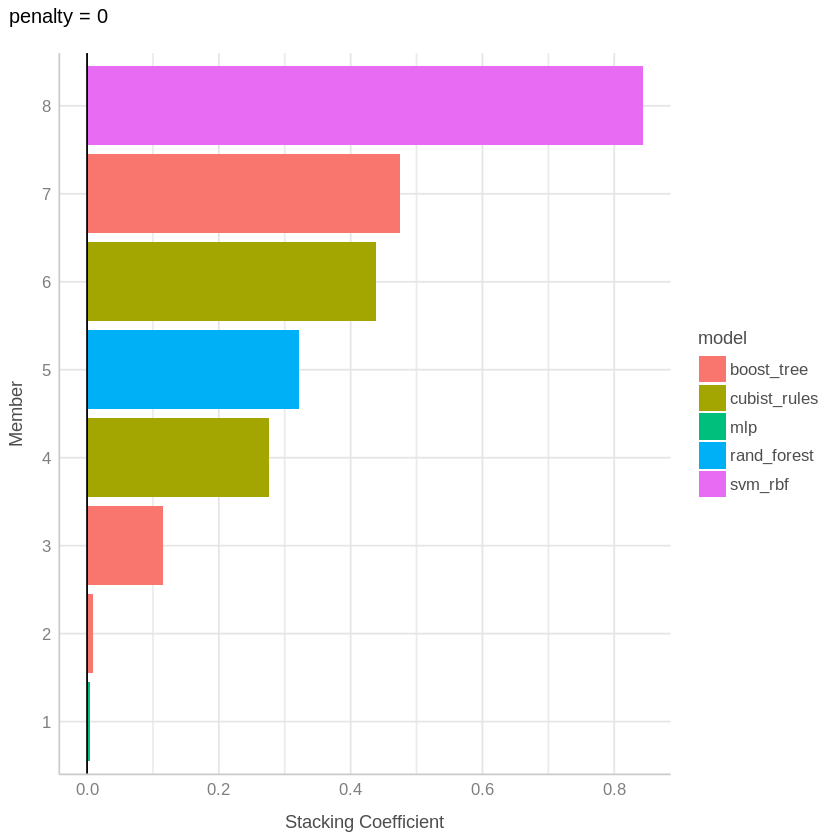

In [22]:
install.packages("see")
library(see) # for nice theme
autoplot(soc_stack, type = "weights") +
  theme_lucid()

### Prediction

### Stack Ensemble

In [23]:
reg_metrics <- metric_set(rmse, rsq)
# get predictions with stack
soc_pred <- predict(soc_stack, test) %>%
  bind_cols(test)

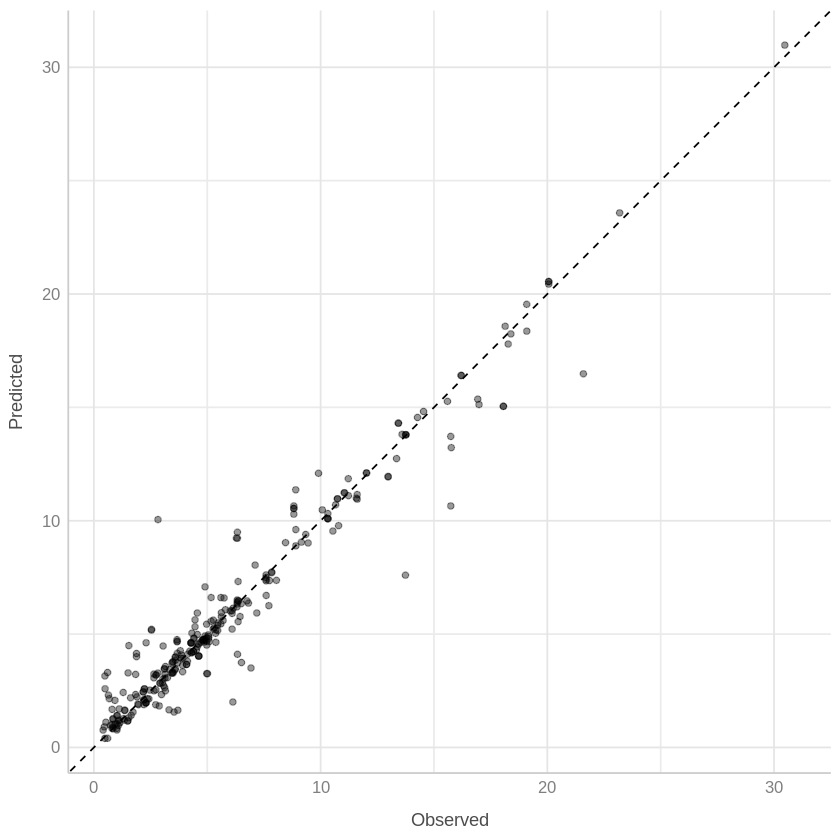

In [24]:
ggplot(soc_pred, aes(x = SOC, y = .pred)) +
  geom_point(alpha = 0.4) +
  coord_obs_pred() +
  labs(x = "Observed", y = "Predicted") +
  geom_abline(linetype = "dashed") +
  theme_lucid()

#### All candidate member models

In [25]:
member_preds <-
  test %>%
  select(SOC) %>%
  bind_cols(
    predict(
      soc_stack,
      test,
      members = TRUE
    )
  )

### Model Performances

#### RMSE

In [26]:
colnames(member_preds) %>%
  map_dfr(
    .f = rmse,
    truth = SOC,
    data = member_preds
  ) %>%
  mutate(member = colnames(member_preds))

.metric,.estimator,.estimate,member
<chr>,<chr>,<dbl>,<chr>
rmse,standard,0.000000,SOC
rmse,standard,1.203960,.pred
rmse,standard,1.377167,rf_res_1_05
rmse,standard,4.933058,lightgbm_res_1_16
rmse,standard,4.933064,lightgbm_res_1_07
rmse,standard,4.933065,lightgbm_res_1_14
rmse,standard,1.447072,cubist_res_1_03
rmse,standard,1.257495,cubist_res_1_15
rmse,standard,5.152214,svm_res_1_09


#### R2

In [27]:
colnames(member_preds) %>%
  map_dfr(
    .f = rsq,
    truth = SOC,
    data = member_preds
  ) %>%
  mutate(member = colnames(member_preds))

.metric,.estimator,.estimate,member
<chr>,<chr>,<dbl>,<chr>
rsq,standard,1.0000000,SOC
rsq,standard,0.9406209,.pred
rsq,standard,0.9269256,rf_res_1_05
rsq,standard,0.5411062,lightgbm_res_1_16
rsq,standard,0.5032946,lightgbm_res_1_07
rsq,standard,0.4839412,lightgbm_res_1_14
rsq,standard,0.9162996,cubist_res_1_03
rsq,standard,0.9353263,cubist_res_1_15
rsq,standard,0.3795743,svm_res_1_09
